# Preface: Google Colab

For this assignment, we will use Google Colab. This will allow us to use resources like GPUs that may not be available on our personal computers, and ensure identical use of external dependencies for everybody. You can use your Stony Brook (`*.stonybrook.edu`) account and save the results on Google Drive.

To get started, go to the [Google Colab Notebook](https://colab.research.google.com/notebooks/). There, you'll find a tutorial called *Overview of Colaboratory Features*, which provides a quick overview on using Google Colab. There is also this concise [Google Colab Tutorial](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj).

Colab is built on top of Jupyter notebook. But remember, inactivity will disconnect your runtime environment.

## Libraries

You are encouraged to use the following libraries as and when needed. This assignment is as much about learning to use available tools, as it is about understanding how to implement simple aspects of computational finance.

- **NumPy**: the most important library for numerical computations in Python; provides support for arrays and matrices; has a large collection of high-level mathematical functions used in linear algebra and probability/statistics.
- **Pandas**: for high-performance, easy-to-use data structures and data analysis; particularly good for data manipulation and analysis; offers `DataFrame` objects, which are ideal for time-series data.
- **SciPy** or **PyTorch**: for optimization, regression, interpolation, etc.
- **Statsmodels**: statistical modeling library built on top of NumPy and SciPy.
- **Matplotlib** and **Seaborn**: for plotting and visualization.

# American Put Options (20 points)

Write your solution to the first question (**American Put Options**) in the cell below. You are free to have additional methods, but the user should be able to call only the `price_american_put_options` function to obtain the results corresponding to each line in the input text or file.

In [ ]:
import numpy as np

def val_americanPut(r, T, n, σ,S0, K):
    # defining the mathematical formula variables for the value of american put options
    dt = T / n
    u = np.exp(σ * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # using the numpy python library to generate storage data array structures
    # the data structure arrays are initialized to zero
    stock_prices = np.zeros((n + 1, n + 1))
    option_values = np.zeros((n + 1, n + 1))

    # Populate stock prices in the binomial tree
    # must increment range values because range is end exclusive
    for j in range(n + 1): # starting at 0
        for i in range(j + 1): # increment to also include current node
            # as given in formula
            stock_prices[i, j] = S0 * (u ** (j - i)) * (d ** i) # the ** in python is a power operator

    # Calculate option values at final nodes
    option_values[:, -1] = np.maximum(K - stock_prices[:, -1], 0)

    # Calculate option values at earlier nodes
    for j in range(n - 1, -1, -1): # decrement to reach preceeding
        for i in range(j + 1): # calculations based on formula
            # Calculate expected option value at node (i, j)
            expected_value = np.exp(-r * dt) * (p * option_values[i, j + 1] + (1 - p) * option_values[i + 1, j + 1])

            # Calculate the exercise value at node (i, j) as given by formula
            exercise_value = max(K - stock_prices[i, j], 0)

            # The option value at node (i, j) is the maximum of expected and exercise value
            option_values[i, j] = max(expected_value, exercise_value)

    # Return the option value at the root node (0, 0)
    return option_values[0, 0]

def price_americanPut(input_text):
    lines = input_text.strip().split('\n')
    for line in lines:
        # Ignore empty lines
        if line.strip() == '':
            continue

        # Extract input parameters from each line by splitting on the tab character
        # Since as given in assignment the data is: r <TAB> T <TAB> n <TAB> σ <TAB> S0 <TAB> K
        r, T, n, σ, S0, K = map(float, line.split('\t'))

        # function call
        option_price = val_americanPut(r, T, int(n), σ, S0, K)
        print(option_price)

# Example usage:
input_text = """0.05\t1.0\t3\t0.25\t100\t110
0.05\t1.0\t3\t0.25\t100\t90"""
price_americanPut(input_text)

13.67883930117455
4.112076968070667


# Asian Call Options (20 points)

Write your solution to the second question (**Asian Call Options**) in the cell below. You are free create additional functions, but the user must be able to call `price_asian_call_options` to obtain the results corresponding to each line in the input text or file.

In [ ]:
import numpy as np

# generates binomial tree
def calc_binomialTree(S0, u, d, n):
    # initialize n+1 (row) by n+1 (col) two dimensional array
    # each index is initialized to 0
    stock_tree = np.zeros((n + 1, n + 1))
    # sets the root of the tree
    stock_tree[0, 0] = S0

    # fill in the values for the binomial tree
    # explores in a depth way - going as deep as possible for a node before recursively moving across breadth
    for i in range(1, n + 1): # increment because range is end exclusive
        # starting at 1 because root node already initialized to initial stock price
        stock_tree[i, 0] = stock_tree[i - 1, 0] *  u # multiply the previous value by the UP MOVEMENT factor
        for j in range(1, i + 1): # same for loop parameter reasoning as above
            stock_tree[i, j] = stock_tree[i - 1, j - 1] * d # multiply by the DOWN MOVEMENT factor

    return stock_tree

# calculates running (cumulative) average at each node in binomial tree
def calc_runAvg(stock_tree, n):
    # represents binomial tree of running averages of the stock prices
    avg_tree = np.zeros((n + 1, n + 1)) # same dimensions as passed in parameter stock tree
    # array is initialized with zeros in the index values

    for i in range(n + 1):
        for j in range(i + 1):
            if i == 0 and j == 0: # implemented once
                avg_tree[i, j] = stock_tree[i, j] # setting the root nodes to be the same values
                # initial condition of running averag = initial stock price
                # initial stock price was set as the root for the passed stock_tree
                # paramater stock_tree was initialized in above function "calc_binomialTree"
            else: # implemented every other time after first iteration (j resets to 0 for every i)
                if j == 0: # this indicates the left most node at the level i
                    # calculating the new average at this node
                    avg_tree[i, j] = (avg_tree[i - 1, j] * i + stock_tree[i, j]) / (i + 1)
                else: # middle or right most node --> uses node right above and to the left of the current node
                    avg_tree[i, j] = (avg_tree[i - 1, j - 1] * i + stock_tree[i, j]) / (i + 1)

    return avg_tree

# financial derivative depends on average stock price over a certain period
def calc_asianCall(stock_tree, avg_tree, strike, p, q, n): # easiest function because previous calculations finished
    option_tree = np.zeros((n + 1, n + 1)) # same dimensions as stock and avg tree
    # indices initialized to zero

    # Payoff at expiration
    for j in range(n + 1):
        option_tree[n, j] = max(avg_tree[n, j] - strike, 0) # based on formula inequality

    # Option price at earlier steps
    for i in range(n - 1, -1, -1): # starting at n-1 and to -1 (since end exclusive) decrement by -1
        for j in range(i + 1): # based on formula
            option_tree[i, j] = (p * option_tree[i + 1, j] + q * option_tree[i + 1, j + 1]) / (1 + p * q)

    return option_tree[0, 0]

def price_asian_call_options(input_text):
    # Parse the input text
    lines = input_text.strip().split('\n')

    for line in lines:
        # Extract parameters from each line
        # r <TAB> T <TAB> n <TAB> σ <TAB> S0 <TAB> K
        risk_free_rate, time, steps, volatility, initial_price, strike_price = map(float, line.strip().split('\t'))

        steps = int(steps)
        delta_t = time / steps

        # Model parameters based on the formulas provided
        u = np.exp(volatility * np.sqrt(delta_t)) # up movement factor
        d = np.exp(-volatility * np.sqrt(delta_t)) # down movement factor
        p = (np.exp(risk_free_rate * delta_t) - d) / (u - d) # probability of an up movement
        q = 1 - p # probability of a down movement

        # function calls to calculate the pricing of the asian financial derivative
        stock_tree = calc_binomialTree(initial_price, u, d, steps) # makes a binomial model tree
        avg_tree = calc_runAvg(stock_tree, steps) # gets a tree representation of the running average
        option_price = calc_asianCall(stock_tree, avg_tree, strike_price, p, q, steps) # gets the option price

        print(option_price)

# Example usage:
input_text = "0.05\t1\t3\t0.2\t100\t110\n0.06\t5\t6\t0.3\t100\t110"
price_asian_call_options(input_text)

1.3634005528361408
12.97435202169238


# Linear Time Series Models

Start by completing the `README` section below, which should provide a precise explanation of how to run your code on the given data (including providing the input tab-separated file).

**Note 1:** At no point should the user/grader need to change anything in your code. For example, the input file should not be hard-coded in your program!

**Note 2:** Your `README` should very clearly mention exactly which function the user should call, and how the user should provide the tab-separated file as input.

**Note 3:** Your implementation must be supported by proper documentation in the form of docstrings, as shown in earlier cells where the function signatures were already provided. (**5 points**)

### README (5 points)

To run the code for the binomial pricing model and linear time series models, follow these steps:

1. Ensure you have Python installed on your system.
2. Install the required libraries mentioned in the code snippet: NumPy, Pandas, SciPy/PyTorch, Statsmodels, Matplotlib, and Seaborn.
3. Download the provided Python script and the dataset file "bond-returns.csv" AND UPLOAD IT TO YOUR GOOGLE DRIVE.
4. Make sure the dataset file is located in YOUR GOOGLE DRIVE WHICH WILL BE MOUNTED IN THE CODE.
5. Run the code cells normally, where your google drive will be mounted. (If this is the first time, it will open a prompt for you to authenticate and verify your google drive.)
6. Then provide the pathname to the file in your google drive (I provided an example in the comments if your file is located in the root of the google drive "Home".)
7. When the code runs after you enter your data set, it will first print the ACF and PACF plots from my manual code implementations. It will then prompt a user input interaction to enter a p and q value to make the code dynamic and avoid hard coding. For the purpose of my analysis as directed by the assignment, I visually inspected the autocorrelation and partial autocorrelation functions and chose p=4 and q=2, so you can enter these values to see what I saw for the estimated model paramters, but you can also test different values<br>
*You will notice commented out lines of code, this is from my debugging where I hard coded some of the variables to make the process of running the code streamlined.<br>
*I implemented an ARIMA model to check my work becasue I was curious what my model prediction would look like when tested against the data, I left this visualization in because it looked cool, but it can be ignored otherwise.<br>
<br>
If you're working with files located on your local machine, you'll need to upload them to Google Colab every time you restart your session or reopen the notebook. Alternatively, this is what my code does, you can mount Google Drive and access files stored in your Google Drive directly from Colab. <br>
Google Colab runs in a cloud-based environment, and by default, it doesn't have access to files on your local machine. Instead, you need to upload files to Google Colab's environment for it to access them.

To upload a file in Google Colab:

Click on the "Files" tab in the sidebar on the left.
Click on the "Upload" button and select the file you want to upload.
Once the file is uploaded, you can access it in your Colab notebook using its file path.<br>
This will prompt you to authorize access to your Google Drive and provide you with a link to generate an authentication code. After authentication, your Google Drive will be mounted, and you can access files in your Google Drive using their file paths.

### AR($p$) and MA($q$) implementation (20 points)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Function to compute Autocorrelation Function (ACF)
def compute_acf(data, lags):
    n = len(data) # extracting the length of the data
    data_mean = np.mean(data)
    acf_values = [] # declare array to store values to plot

    # Compute autocorrelation for each lag - allowed to implement with the python numpy library
    for lag in range(lags + 1): # increment by one to include lag of 10 (range is end exclusive)
        lagged_data = np.roll(data, -lag)  # Shift data by the lag value
        # implementing the formulas introduced in lectures and as defined in the textbook
        covariance = np.sum((data - data_mean) * (lagged_data - data_mean)) # code interpretation of forumla for covariance
        autocorrelation = covariance / np.sum((data - data_mean) ** 2) # code interpretation of formula for autocorrelation
        acf_values.append(autocorrelation) # add the data to the storage data structure

    return acf_values # return the calcualted autocorrelation values to plot

# Function to compute Partial Autocorrelation Function (PACF)
def compute_pacf(data, lags):
    pacf_values = [1.0]  # PACF at lag 0 is always 1

    # allowed to use numpy library by python
    for lag in range(1, lags + 1): # increment lags to capture lag=10 since range is end exclusive
        # Create the lagged matrix
        lagged_matrix = np.column_stack([np.roll(data, -i) for i in range(1, lag + 1)])
        original_data = data[:-lag] # negative index starts from the end
        lagged_data = lagged_matrix[:-lag]

        # Adding a constant column (intercept term)
        intercept = np.ones((lagged_data.shape[0], 1))
        X = np.hstack((intercept, lagged_data))  # Design matrix with a constant term
        y = original_data  # Dependent variable

        # Compute the OLS coefficients since cannot use OLS library from python library
        # beta = (X^T * X)^-1 * X^T * y --> code implements this mathematical forumla
        # breaks math into smaller components
        X_transpose = X.T
        XtX_inv = np.linalg.inv(X_transpose @ X)  # (X^T * X)^-1
        beta = XtX_inv @ (X_transpose @ y)  # (X^T * X)^-1 * X^T * y

        # Partial correlation for current lag is the last coefficient (without the intercept term)
        pacf_values.append(beta[-1])

    return pacf_values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ACF and PACF visualization (10 points)

In [ ]:
# Function to plot ACF and PACF
def plot(data, lags=10):
    acf_values = compute_acf(data, lags)
    pacf_values = compute_pacf(data, lags)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # ACF plot
    axes[0].stem(
        range(lags + 1),
        acf_values,
        basefmt=' ',
        linefmt='b-',
        markerfmt='bo',
        use_line_collection=True
    )
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("Autocorrelation")
    axes[0].grid(True)

    # PACF plot
    axes[1].stem(
        range(lags + 1),
        pacf_values,
        basefmt=' ',
        linefmt='r-',
        markerfmt='ro',
        use_line_collection=True
    )
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("Partial Autocorrelation")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Not included in assignment, but checking model characteristics
def plot_arima_forecast(bond_5_years, arima_results):
    plt.figure(figsize=(12, 6))

    # Plot the original data
    plt.plot(bond_5_years, label='Original Data')

    # Plot the in-sample forecast
    plt.plot(arima_results.fittedvalues, label='In-Sample Forecast', linestyle='--')

    plt.xlabel("Time")
    plt.ylabel("Bond Index")
    plt.title("ARIMA Model Forecast")
    plt.legend()
    plt.show()

def fit_arima(data, order):
    arima_model = ARIMA(data, order=order)
    arima_results = arima_model.fit()

    return arima_results

A greater lag value is more likely to overfit while a lesser lag value is more like to underfit.

Please enter the file path in your Google Drive: /content/drive/MyDrive/bond-returns.csv
File path provided: /content/drive/MyDrive/bond-returns.csv


<ipython-input-69-c7353b849e1c>:9: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes[0].stem(
<ipython-input-69-c7353b849e1c>:23: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  axes[1].stem(


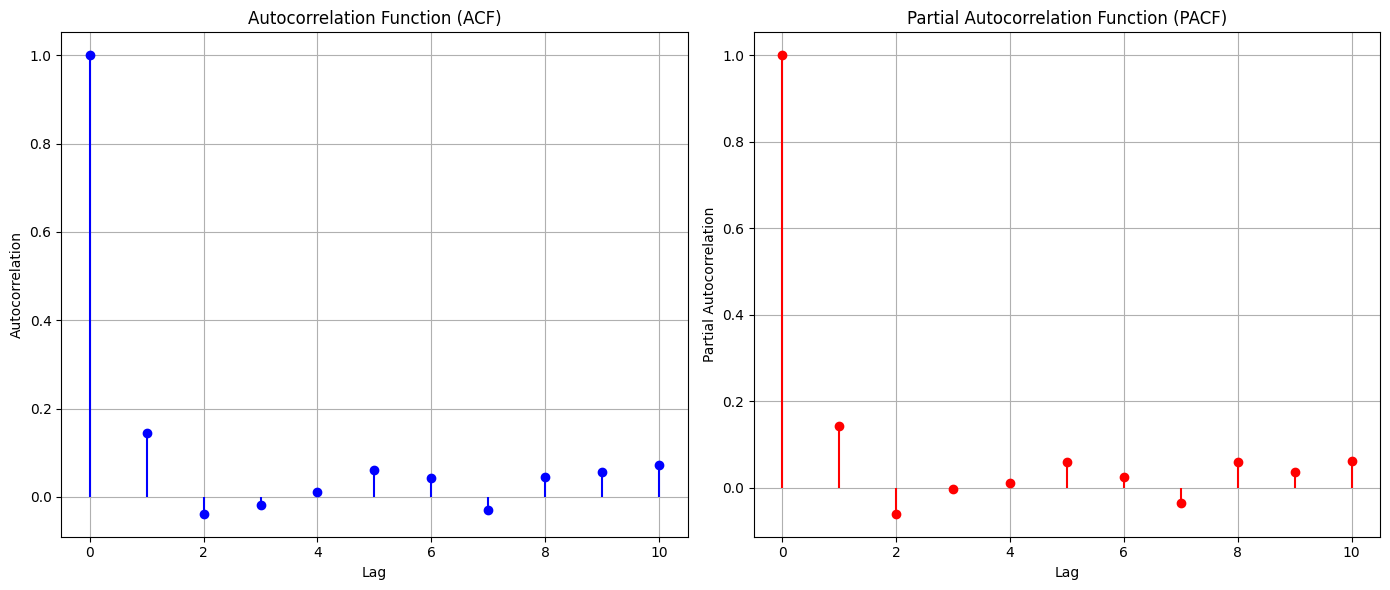

Analyze ACF and PACF to determine the order of the models
Required to use the autocorrelation and the partial autocorrelation functions.
Enter the p value for ACF (for analysis assignment purposes used [p=4])4
Enter the q value for PACF (for analysis assignment purposes used [q=2])2


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR Model Parameters: const     0.004590
ar.L1     0.152000
ar.L2    -0.059538
ar.L3    -0.004780
ar.L4     0.010526
sigma2    0.000189
dtype: float64
MA Model Parameters: const     0.004592
ma.L1     0.151298
ma.L2    -0.036732
sigma2    0.000189
dtype: float64


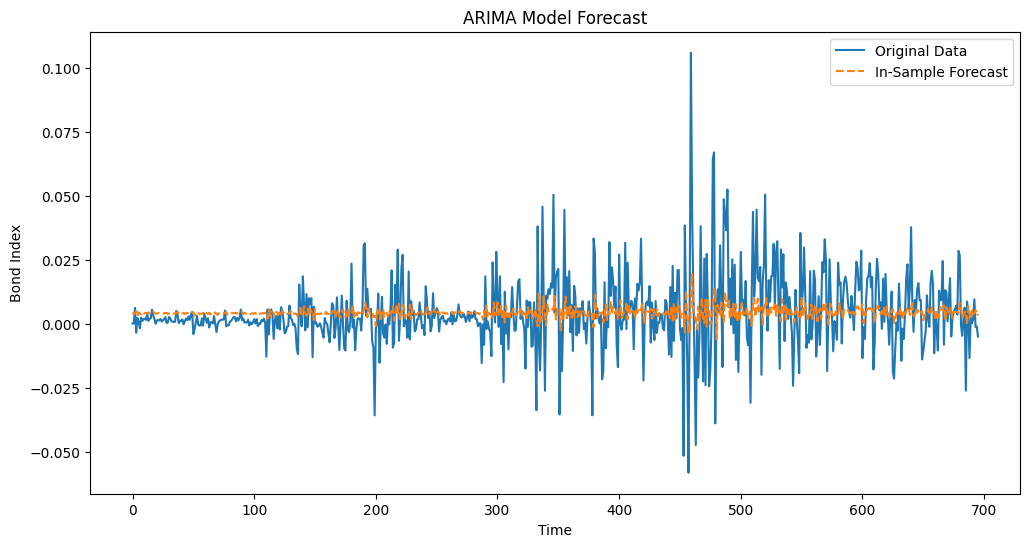

In [ ]:
# Main code to run the analysis (no user interaction displayed)
def main(file_path):
    print("File path provided:", file_path)
    data = pd.read_csv(file_path, sep='|', header=None)

    # Select the column for bond index with maturity of 5 years
    bond_5_years = data.iloc[:, 3]

    # Plot ACF and PACF for lags
    plot(bond_5_years, 10)
    print("Analyze ACF and PACF to determine the order of the models")
    print("Required to use the autocorrelation and the partial autocorrelation functions.")

    # p, q = 4, 2 --> used to hard code and test code, these were the values I selected in my analysis
    # makes code dynamic
    p_value = input("Enter the p value for ACF (for analysis assignment purposes used [p=4])")
    q_value = input("Enter the q value for PACF (for analysis assignment purposes used [q=2])")
    p = int(p_value)
    q = int(q_value)

    # Variables for paramter estimations
    ar_model = ARIMA(bond_5_years, order=(p, 0, 0))  # AR(p)
    ar_results = ar_model.fit()
    ar_params = ar_results.params

    ma_model = ARIMA(bond_5_years, order=(0, 0, q))  # MA(q)
    ma_results = ma_model.fit()
    ma_params = ma_results.params

    # Print AR and MA model parameters
    print("AR Model Parameters:", ar_params)
    print("MA Model Parameters:", ma_params)

    # CHANGE BACK TO P AND Q (RESPECTIVE) - visually idenitfying the correct lag
    # arima_results_base = fit_arima(bond_5_years, (1, 0, 1)) - lowest lag base (underfit)
    arima_results = fit_arima(bond_5_years, (p, 0, q))
    # arima_results_check = fit_arima(bond_5_years, (10, 0, 10)) - highest lag check (overfit)

    plot_arima_forecast(bond_5_years, arima_results)

if __name__ == "__main__": # makes the code dynamic
    # Specify the file path in your Google Drive
    # Example: '/content/drive/MyDrive/bond-returns.csv'
    # (this is the path I used in testing - csv was in my home directory of my google drive)
    file_path = input("Please enter the file path in your Google Drive: ")
    # file_path = '/content/drive/MyDrive/bond-returns.csv'
    main(file_path)

### The Simple Autoregressive Model AR($p$) (10 points)

- TODO: clearly state your choice of $p$
- TODO: clearly state your estimated parameter values (for the sake of easier interpretaion, please use the same symbols we have used in our lectures)
- TODO: How did you arrive at this choice of $p$? Provide a precise description of your process and a brief justification.

The AR model uses past observations to predict the future.<br>
Choice of p: p=4 <br>
Estimated parameter values: AR coefficient constant = 0.004590 and sigma is 0.000189 <br>
Process: The ACF plot was analyzed to determine the lag where autocorrelation sharply drops off to zero and where proceeding lags tend towards and around 0. At a lag of 4 the value autocorrelation function was close to 0 (the autocorrelation drops off indicating no further correlation beyond this lag point - in my case 4 - point), and for greater increments of the lag, the values of the autocorrelation function tended around 0.<br>
Justification: A lag of 4 was chosen as it captures the significant autocorrelation observed in the ACF plot while avoiding overfitting. In other words, when I checked my work with the AIRMA model, the orange line (my predicted forecast model) captured the general patterns and trends of the blue line (oiriginal data) but in proportions of the severity of the significant data poitns. To explain further, it captures the sharp and extreme maximums and minimums in the orange line's reflective patterns of scaled peaks and pits, but it only recgonizes softly the smaller characteristics in the original data blue line, without overfitting the model prediction orange line. The model fits to the original data where it reflects the original data patterns so it doesn't underfit, but it also does not overfit where it pays too close attention to the individual data points.


### The Moving Average Model MA($q$) (10 points)

- TODO: clearly state your choice of $q$
- TODO: clearly state your estimated parameter values (for the sake of easier interpretaion, please use the same symbols we have used in our lectures)
- TODO: How did you arrive at this choice of $q$? Provide a precise description of your process and a brief justification.

The MA model uses past forecast errors to predict future values. The value of q determines how many past error terms are included in the model to predict future values.<br>
Choice of q: q=7 <br>
Estimated parameter values: MA coefficient constant = 0.004592 and sigma is 0.000189<br>
Process: The PACF plot was examined to identify the lag where partial autocorrelation drops to 0. A lag of 2 was selected based on the sharp drop to zero in the partial autocorrelation at lag 2 and then proceedings lags jumping to be approximately level. This drop is an indication of how many past errors are influencing the current value and I looked for the first significant spike in the ACF plot where the autocorrelation drops to near-zero values. <br>
Justification: A lag of 2 was chosen as it captures the significant partial autocorrelation observed in the PACF plot while maintaining model prediction to avoid underfitting but also checking against overfitting. It was the first drop in the partial correlation to near 0.

# Collaboration and Resource Use Policy

You may discuss any details of this assignment at a conceptual level with anyone. In fact, discussion of ideas and helping each other to gain a better understanding of the concepts and the mathematical principles is encouraged. But any written answers (natural language or programming language) must be entirely your own original work.

You are also encouraged to use the libraries mentioned at the start of this notebook. The use of online resources (e.g., StackOverflow) that can help you understand specific functions in these libraries is also encouraged.

There must not be any collaboration in programming (including the design, implementation, and debugging of code). There must not be any code in your submission that is written by anyone other than you (whether human or AI). Submitted code will be checked against other submissions AND against AI-generated code, and evidence of plagiarism will lead to academic dishonesty charges.

# What to submit?

**This assignment is due by 11:59 pm, APR 30 (Tuesday)**

1. Make your colab notebook publicly accessible. You can do this by clicking "Share" on the top-right corner of your notebook and make sure "anyone with the link" can view your notebook. Also make sure that viewers are allowed to download your notebook. Then, **put this link in the comment section of your submission on Brightspace**.

2. Create an empty folder (locally, on your computer) called `firstname-lastname-cse390-hw3`. For example, John Doe will create `john-doe-cse354-hw3`.
    * Download this colab notebook with all the questions (code as well as the text questions) implemented/answered. This will be a single Python notebook, as a `.ipynb` file. Put the notebook in your folder.
    
    Zip this folder (i.e., create `firstname-lastname-cse390-hw3.zip`) and submit on Brightspace.

Once unzipped, your submission is expected to have the following structure:

```
john-doe-cse354-hw1
└── CSE390-Spring2024-HW3.ipynb
```